In [2]:
!pip3 install opendatasets

In [3]:
import opendatasets as od
import pandas as pd
import os
import shutil
import librosa

In [ ]:
od.download('https://www.kaggle.com/datasets/makvel/mer500')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ishitavohra
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/makvel/mer500


100%|██████████| 979M/979M [00:14<00:00, 72.9MB/s]


In [ ]:
!unzip /content/mer500/Angry.zip

Archive:  /content/mer500/Angry.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/mer500/Angry.zip or
        /content/mer500/Angry.zip.zip, and cannot find /content/mer500/Angry.zip.ZIP, period.


In [ ]:
lyrics = pd.read_csv('hindi_songs_lyrics.csv')
lyrics['Song_emotion'] = len(lyrics)*[None]
lyrics['Song_location'] = len(lyrics)*[None]

In [ ]:
print(len(lyrics))

90


In [ ]:
base_dir = '/content/mer500/'
extracted_dir = '/content/extracted_audio'
os.makedirs(extracted_dir, exist_ok=True)

for folder_name in os.listdir(base_dir):
  if folder_name.startswith(".ipynb_check"):
      continue
  folder_path = os.path.join(base_dir, folder_name)
  folder_path = os.path.join(folder_path, folder_name)

  for filename in os.listdir(folder_path):
      if filename.endswith('.wav'):
          song_id = filename
          if str(song_id) in list(lyrics['Song_id']):
            source_path = os.path.join(folder_path, filename)
            destination_path = os.path.join(extracted_dir, filename)
            idx = list(lyrics['Song_id']).index(song_id)
            lyrics.loc[idx, 'Song_emotion'] = folder_name
            lyrics.loc[idx, 'Song_location'] = destination_path
            shutil.copy2(source_path, destination_path)

print("Extraction complete")

Extraction complete


In [12]:
lyrics = pd.read_csv('/content/hindi_song_lyrics_with_emotion.csv')
len(lyrics)

90

In [13]:
unique_labels = lyrics['Song_emotion'].unique()
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
lyrics['Song_emotion'] = lyrics['Song_emotion'].map(label_to_int)

In [14]:
label_to_int

{'Romantic': 0, 'Devotional': 1, 'Party': 2, 'Happy': 3, 'Sad': 4, 'Angry': 5}

In [16]:
lyrics.tail()

,Unnamed: 0,Song_id,Lyrics,Song_name,Song_emotion,Song_location
85,85,611.wav,"जनम-जनम से तेरा-मेरा बैर हो, रब्बा ख़ैर मैं तेर...","mei teri dushamn, dushman tu mera",5,./extracted_audio/611.wav
86,86,612.wav,तू फूल बने पतझड़ का तुझपे बाहर ना आए कभी मेरी ...,mera dushman tu mere dosti ko tarse,5,./extracted_audio/612.wav
87,87,613.wav,कितने अटल थे तेरे इरादे याद तो कर तू वफ़ा के वा...,"tu hamari thi, jaan se pyari thi",5,./extracted_audio/613.wav
88,88,614.wav,"याद है मुझ को तूने कहा था ""तुम से नहीं रूठेंगे...",kya hua tera wada,5,./extracted_audio/614.wav
89,89,615.wav,तड़प-तड़प के इस दिल से आह निकलती रही मुझको सज़ा द...,NaN,5,./extracted_audio/615.wav


In [17]:
!pip install torch --index-url https://download.pytorch.org/whl/cu118
!pip install transformers
!pip install sklearn

Looking in indexes: https://download.pytorch.org/whl/cu118
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("google/muril-base-cased")
model = AutoModel.from_pretrained("google/muril-base-cased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/113 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/953M [00:00<?, ?B/s]

In [31]:
def get_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).numpy()
    return embeddings

lyrics = lyrics.dropna(subset=['Song_emotion'])
lyrics['embeddings'] = lyrics['Lyrics'].apply(get_embeddings)
lyrics['embeddings'] = lyrics['embeddings'].apply(lambda x: x[0])

# lyrics['embeddings'] = lyrics['embeddings'].apply(lambda x: list(x[0]))

In [32]:
SR = 22050
N_MELS = 128
HOP_LENGTH = 512
DURATION = 15
IMG_HEIGHT = N_MELS
IMG_WIDTH = int((SR * DURATION) / HOP_LENGTH)

def get_mel_spectrogram(file_path, sr=SR, n_mels=N_MELS, hop_length=HOP_LENGTH, duration=DURATION):
    y, _ = librosa.load(file_path, sr=sr, duration=duration)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    if mel_spectrogram_db.shape[1] != IMG_WIDTH:
        mel_spectrogram_db = librosa.util.fix_length(mel_spectrogram_db, size=IMG_WIDTH, axis=1)
    mel_spectrogram_flattened = mel_spectrogram_db.flatten()
    return mel_spectrogram_flattened

lyrics['audio_features'] = lyrics['Song_location'].apply(get_mel_spectrogram)

<ipython-input-32-b15c674627be>:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr, duration=duration)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [33]:
lyrics = lyrics.dropna(subset=['audio_features', 'embeddings'])
lyrics['combined_features'] = lyrics.apply(lambda row: np.concatenate((row['embeddings'], row['audio_features'])), axis=1)

In [34]:
X_combined = np.array(lyrics['combined_features'].tolist())
y_combined = np.array(lyrics['Song_emotion'])

X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42, stratify=y_combined)

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [38]:
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf', 'linear']}
grid_svc = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)
grid_svc.fit(X_train, y_train)
print(grid_svc.best_params_)
svm_pred = grid_svc.predict(X_test)
print(classification_report(y_test, svm_pred))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.133 total time=   2.2s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.133 total time=   1.2s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.143 total time=   1.6s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.143 total time=   3.6s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.143 total time=   0.5s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.733 total time=   0.3s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.600 total time=   0.4s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.643 total time=   0.3s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.643 total time=   0.3s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.643 total time=   0.3s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.133 total time=   0.4s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf

In [39]:
param_grid = {'C': [0.1, 1, 10, 100]}
grid_lr = GridSearchCV(LogisticRegression(max_iter=10000), param_grid, refit=True, verbose=3)
grid_lr.fit(X_train, y_train)
print(grid_lr.best_params_)
lr_pred = grid_lr.predict(X_test)
print(classification_report(y_test, lr_pred))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .............................C=0.1;, score=0.600 total time=  10.9s
[CV 2/5] END .............................C=0.1;, score=0.600 total time=  10.5s
[CV 3/5] END .............................C=0.1;, score=0.714 total time=   8.4s
[CV 4/5] END .............................C=0.1;, score=0.643 total time=   8.1s
[CV 5/5] END .............................C=0.1;, score=0.714 total time=   9.3s
[CV 1/5] END ...............................C=1;, score=0.667 total time=   5.1s
[CV 2/5] END ...............................C=1;, score=0.600 total time=   3.9s
[CV 3/5] END ...............................C=1;, score=0.643 total time=   9.1s
[CV 4/5] END ...............................C=1;, score=0.643 total time=   4.1s
[CV 5/5] END ...............................C=1;, score=0.643 total time=   5.2s
[CV 1/5] END ..............................C=10;, score=0.667 total time=   5.4s
[CV 2/5] END ..............................C=10;,

In [40]:
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}

grid_rfc = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, refit=True, verbose=3)
grid_rfc.fit(X_train, y_train)

print(grid_rfc.best_params_)
rf_pred = grid_rfc.predict(X_test)
print(classification_report(y_test, rf_pred))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.533 total time=   0.4s
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.733 total time=   0.3s
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.500 total time=   0.2s
[CV 4/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.500 total time=   0.3s
[CV 5/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.643 total time=   0.2s
[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.533 total time=   0.5s
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.800 total time=   0.5s
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.500 to

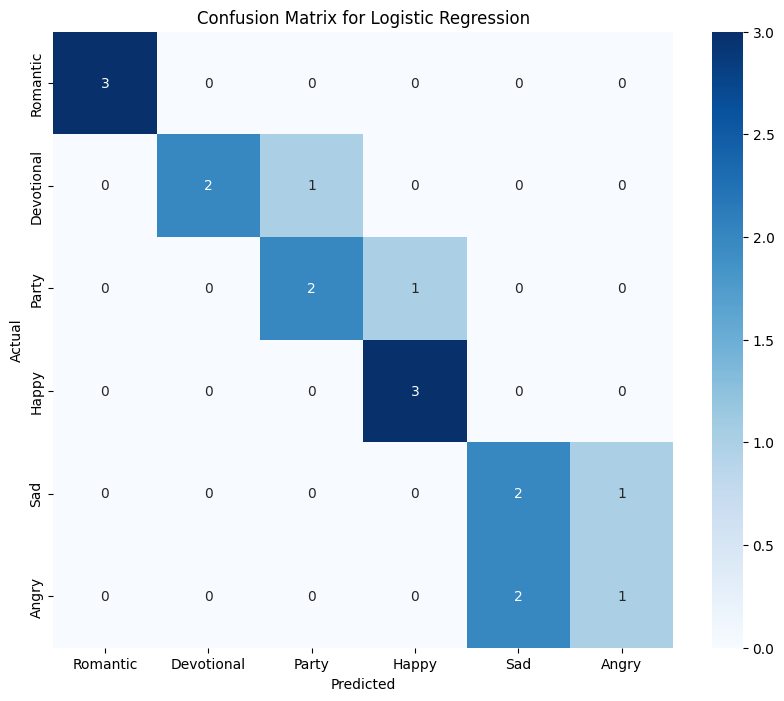

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

lr_pred = grid_lr.predict(X_test)

cm = confusion_matrix(y_test, lr_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

In [44]:
best_model = grid_lr.best_estimator_

int_to_label = {idx: label for label, idx in label_to_int.items()}

for class_label in np.unique(y_test):
    class_indices = np.where(y_test == class_label)[0]
    for test_index in class_indices:
        example_input = X_test[test_index]
        example_prediction = best_model.predict(example_input.reshape(1, -1))[0]
        song_info = lyrics.iloc[lyrics.index[lyrics['combined_features'].apply(lambda x: np.array_equal(x, example_input))].tolist()[0]]

        if class_label == example_prediction:
            print("File:", song_info["Song_id"])
            print("Lyrics:", song_info["Lyrics"])
            print(f"Actual Emotion: {int_to_label[class_label]}")
            print(f"Predicted Emotion: {int_to_label[example_prediction]}")
            print("-" * 20)
            break

File: 307.wav
Lyrics: जग घूमे थारे जैसा ना कोई जग घूमे थारे जैसा ना कोई
Actual Emotion: Romantic
Predicted Emotion: Romantic
--------------------
File: 104.wav
Lyrics: आई मैं तोरे अंगना मां भवानीआई मैं तोरे अंगना मां भवानी
Actual Emotion: Devotional
Predicted Emotion: Devotional
--------------------
File: 415.wav
Lyrics: अरे अभी तो पार्टी शुरू हुई है। अरे अभी तो पार्टी शुरू

Actual Emotion: Party
Predicted Emotion: Party
--------------------
File: 13.wav
Lyrics: हमारा मेरा मेरा चटकारे वाला बीचबीच में बीच में लग जाता है मेरा
Actual Emotion: Happy
Predicted Emotion: Happy
--------------------
File: 204.wav
Lyrics: तूने मेरे जाना कभी नहीं जाना इश्क मेरा दर्द मेरा तूने मेरे जाना कभी नहीं जाना इश्क मेरा दर्द मेरा
Actual Emotion: Sad
Predicted Emotion: Sad
--------------------
File: 615.wav
Lyrics: तड़प-तड़प के इस दिल से आह निकलती रही मुझको सज़ा दी प्यार की, ऐसा क्या गुनाह किया? तो लूट गए, हाँ, लूट गए, तो लूट गए हम तेरी मोहब्बत में
Actual Emotion: Angry
Predicted Emotion: Angry
----------------

In [47]:
def get_mel_spectrogram_unflattened(file_path, sr=SR, n_mels=N_MELS, hop_length=HOP_LENGTH, duration=DURATION):
    y, _ = librosa.load(file_path, sr=sr, duration=duration)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    if mel_spectrogram_db.shape[1] != IMG_WIDTH:
        mel_spectrogram_db = librosa.util.fix_length(mel_spectrogram_db, size=IMG_WIDTH, axis=1)
    return mel_spectrogram_db

lyrics['audio_features_raw'] = lyrics['Song_location'].apply(get_mel_spectrogram_unflattened)

lyrics = lyrics.dropna(subset=['audio_features_raw', 'embeddings'])

<ipython-input-47-5047728b24a5>:2: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr, duration=duration)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [48]:
from tensorflow.keras import layers, models

def build_combined_model(input_audio_shape, input_text_shape, num_classes):
    audio_input = layers.Input(shape=input_audio_shape, name="audio_input")
    x_audio = layers.Reshape((input_audio_shape[0], input_audio_shape[1], 1))(audio_input)
    x_audio = layers.Conv2D(64, (3, 3), activation='relu')(x_audio)
    x_audio = layers.MaxPooling2D((2, 2))(x_audio)
    x_audio = layers.Conv2D(32, (3, 3), activation='relu')(x_audio)
    x_audio = layers.MaxPooling2D((2, 2))(x_audio)
    x_audio = layers.Flatten()(x_audio)

    text_input = layers.Input(shape=input_text_shape, name="text_input")
    x_text = layers.Dense(256, activation='relu')(text_input)
    x_text = layers.Dense(128, activation='relu')(x_text)

    combined = layers.concatenate([x_audio, x_text])

    x = layers.Dense(64, activation='relu')(combined)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    output = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=[audio_input, text_input], outputs=output)

    return model

In [49]:
X = lyrics[['audio_features_raw', 'embeddings']]
y = lyrics['Song_emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_audio = np.stack(X_train['audio_features_raw'].values)
X_train_text = np.stack(X_train['embeddings'].values)

X_test_audio = np.stack(X_test['audio_features_raw'].values)
X_test_text = np.stack(X_test['embeddings'].values)

In [50]:
input_audio_shape = (N_MELS, IMG_WIDTH)
input_text_shape = (lyrics['embeddings'].iloc[0].shape[0],)

model = build_combined_model(input_audio_shape, input_text_shape, num_classes=len(unique_labels))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit([X_train_audio, X_train_text], y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 9s/step - accuracy: 0.1795 - loss: 107.5111 - val_accuracy: 0.2000 - val_loss: 68.4653
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.2679 - loss: 143.0990 - val_accuracy: 0.2000 - val_loss: 33.6201
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.2367 - loss: 60.8642 - val_accuracy: 0.1333 - val_loss: 4.6589
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.2016 - loss: 10.1353 - val_accuracy: 0.2000 - val_loss: 3.2060
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.1561 - loss: 5.8517 - val_accuracy: 0.3333 - val_loss: 1.8433
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.2471 - loss: 3.5242 - val_accuracy: 0.6000 - val_loss: 1.4171
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.3706 - loss: 1.6490 - val_accuracy: 0.4000 - val_loss: 1.4608
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.3902 - loss: 1.5337 - val_accuracy: 0.2667 - val_

In [51]:
y_pred = model.predict([X_test_audio, X_test_text])
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes, target_names=[int_to_label[i] for i in range(len(unique_labels))]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
              precision    recall  f1-score   support

    Romantic       0.00      0.00      0.00         3
  Devotional       0.25      0.33      0.29         3
       Party       0.00      0.00      0.00         3
       Happy       0.75      1.00      0.86         3
         Sad       0.67      0.67      0.67         3
       Angry       0.50      0.67      0.57         3

    accuracy                           0.44        18
   macro avg       0.36      0.44      0.40        18
weighted avg       0.36      0.44      0.40        18



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [52]:
test_loss, test_acc = model.evaluate([X_test_audio, X_test_text], y_test)
print(f"Test accuracy: {test_acc}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step - accuracy: 0.4444 - loss: 1.7817
Test accuracy: 0.4444444477558136
